## Setup

In [1]:
# start notebook with command:
# jupyter notebook --NotebookApp.iopub_data_rate_limit=10000000000
import keras
import os
import numpy as np
import matplotlib.pyplot as plt
from keras import layers
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout
from keras import models
from keras import activations
from keras.activations import relu, sigmoid
from keras import losses
from keras import regularizers
from keras import optimizers

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

from keras.applications import VGG16
from keras.preprocessing import image

IMAGE_SIZE = 150
CAT_FILENAME_PATTERN = 'cat.{}.jpg'
DOG_FILENAME_PATTERN = 'dog.{}.jpg'

base_dir = os.path.expanduser('~/data/kaggle/dogs-vs-cats')
orig_data_dir = os.path.join(base_dir, 'train')

small_dir = os.path.join(base_dir, 'small')

models_dir = os.path.join(small_dir, 'models')

train_dir = os.path.join(small_dir, 'train')
valid_dir = os.path.join(small_dir, 'validation')
test_dir = os.path.join(small_dir, 'test')

train_dogs_dir = os.path.join(train_dir, 'dogs')
train_cats_dir = os.path.join(train_dir, 'cats')
valid_dogs_dir = os.path.join(valid_dir, 'dogs')
valid_cats_dir = os.path.join(valid_dir, 'cats')
test_dogs_dir = os.path.join(test_dir, 'dogs')
test_cats_dir = os.path.join(test_dir, 'cats')


def plot_history(history):
    hist_dict = history.history
    loss_values = hist_dict['loss']
    val_loss_values = hist_dict['val_loss']
    acc_values = hist_dict['acc']
    val_acc_values = hist_dict['val_acc']

    epochs = range(1, len(loss_values) + 1)

    fig, (ax0, ax1) = plt.subplots(nrows=2, ncols=1,
                                   sharex='all', figsize=(10, 7))
    ax0.plot(epochs, loss_values, 'bo')
    ax0.plot(epochs, val_loss_values, 'b+')
    ax0.set_ylabel('Loss')

    ax1.plot(epochs, acc_values, 'bo')
    ax1.plot(epochs, val_acc_values, 'b+')
    ax1.set_ylabel('Accuracy')

    plt.show()


vgg16 = VGG16(weights='imagenet',
              include_top=False,
              input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

img_path = os.path.join(test_cats_dir, CAT_FILENAME_PATTERN.format(1700))

img = image.load_img(img_path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255

print(img_tensor.shape)

plt.imshow(img_tensor[0])

# Build activation model

layer_name = 'block3_conv1'
filter_index = 0

import keras.backend as K

layer_output = vgg16.get_layer(layer_name).output
loss = K.mean(layer_output[:, :, :, filter_index])
grads = K.gradients(loss, vgg16.input)[0]
# trick for improving learning speed
grads /= K.sqrt(K.mean(K.square(grads)) + 1e-5)

iterate = K.function([vgg16.input], [loss, grads])

loss_value, grads_vaue = iterate([np.random.rand(1, 150, 150, 3)])

input_data_image = np.random.rand(1, IMAGE_SIZE, IMAGE_SIZE, 3) * 20 + 128

step = 1
for i in range(40):
    loss_value, grads_value = iterate([input_data_image])
    input_data_image += grads_value * step
    print('Step', i, 'out of', 40)


def deprocess_image(x):
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1
    # clip
    x += 0.5
    x = np.clip(x, 0, 1)
    # convert to rgb
    x *= 255
    x = np.clip(x, 0, 255).astype(np.uint8)
    return x

Using TensorFlow backend.


(1, 150, 150, 3)
Step 0 out of 40
Step 1 out of 40
Step 2 out of 40
Step 3 out of 40
Step 4 out of 40
Step 5 out of 40
Step 6 out of 40
Step 7 out of 40
Step 8 out of 40
Step 9 out of 40
Step 10 out of 40
Step 11 out of 40
Step 12 out of 40
Step 13 out of 40
Step 14 out of 40
Step 15 out of 40
Step 16 out of 40
Step 17 out of 40
Step 18 out of 40
Step 19 out of 40
Step 20 out of 40
Step 21 out of 40
Step 22 out of 40
Step 23 out of 40
Step 24 out of 40
Step 25 out of 40
Step 26 out of 40
Step 27 out of 40
Step 28 out of 40
Step 29 out of 40
Step 30 out of 40
Step 31 out of 40
Step 32 out of 40
Step 33 out of 40
Step 34 out of 40
Step 35 out of 40
Step 36 out of 40
Step 37 out of 40
Step 38 out of 40
Step 39 out of 40


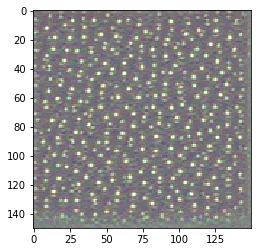

In [8]:
plt.imshow(deprocess_image(input_data_image[0]));

In [9]:
vgg16.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

## Visualize single filter

In [2]:
def generate_pattern(layer_name, filter_index, size=IMAGE_SIZE):
    layer_output = vgg16.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index])

    grads = K.gradients(loss, vgg16.input)[0]
    grads /= K.sqrt(K.mean(K.square(grads)) + 1e-5)

    iterate = K.function([vgg16.input], [loss, grads])

    input_data_image = np.random.rand(1, size, size, 3) * 20 + 128
    step = 1
    for i in range(40):
        loss_value, grads_value = iterate([input_data_image])
        input_data_image += grads_value * step

    img = input_data_image[0]
    return deprocess_image(img)

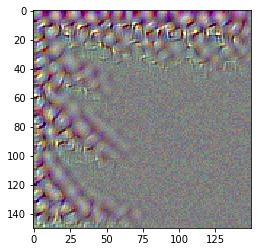

In [15]:
plt.imshow(generate_pattern('block3_conv2', 0))

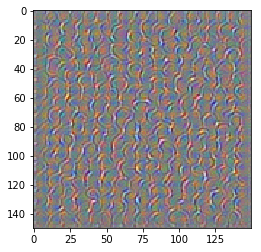

In [16]:
plt.imshow(generate_pattern('block3_conv2', 1))

## Visualize whole layer